In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


일단 전체 유저를 대상으로 총결제량을 예측하는 최적 모델을 찾을 것이다. 이 모델이 여전히 0인 유저, 20 이상인 유저를 제대로 잡아내지 못한다면 아래 과정을 거칠 것이다. 

총결제량이 20 이상인 경우 잔존인 유저의 수가 80% 이상으로 높으므로, 총결제량 20인 유저를 분류하는 이진분류 모델을 최적화할 것이다. 

현재 40000명 유저 중 16000명이 무과금 유저이며, 모델 예측에서는 0인 유저를 총결제량 20 이상으로까지 예측하는 상황이므로 이들을 바르게 예측하고 있는지 이진 분류 또한 필요하다. 

이 작업이 완료되면 총결제량 0초과 20이하인 유저를 대상으로 총결제량을 예측하는 회귀 모델을 적용할 것이다. 

In [0]:
import pandas as pd
import numpy as np
from pandas import DataFrame
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import matplotlib.pyplot  as plt
import seaborn as sns
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_squared_error as mse
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [0]:
data = pd.read_csv('/content/drive/My Drive/merge_all_flatten.csv')    
train_label = pd.read_csv('/content/drive/My Drive/train_label_add.csv')
train_label = train_label.sort_values('acc_id')

In [0]:
del data['minus']
del data['plus']

In [0]:
def week_login(data):
    for i in range(0,4):    
        data['week'+str(i+1)+'_log'] = (data[str(i+1)] + data[str(i+2)] + data[str(i+3)] + data[str(i+4)] + data[str(i+5)] + data[str(i+6)] + data[str(i+7)]) / 7
        
    data = data.drop(['1','2','3','4','5','6','7','8','9','10','11','12','13','14',
                                               '15','16','17','18','19','20','21','22','23','24','25','26','27','28'], axis=1)

    return data

In [0]:
data = week_login(data)

In [0]:
# 어차피 64인 유저는 기대이익에서 0이기 때문에, 64인 유저는 제외하고 total 분석.
# 잔존은 잔존이고, 64인 유저의 결제량을 같이 학습해야 정보량이 많아지지 않겠냐고 하지만, 잔존과 이탈자는 다른 특성을 가질 것이라 예측되므로 제거 후 학습 
# 대부분을 64로 예측하고 있다는 건 total_spent가 모두 64로 나눠지고 있다는 뜻이므로 일평균결제량으로 예측하는 게 나을 수도 있음
data_lbl = pd.merge(data, train_label, on='acc_id')
data_63_lbl = data_lbl[data_lbl['survival_time']!=64]
data_63 = data_63_lbl.drop(['total_spent','survival_time','secession','amount_spent_y','Unnamed: 0'],axis=1) # 64인 유저 걸러냄

In [8]:
data_63.columns

Index(['acc_id', 'temp_cnt_x', 'private_shop', 'level_x', 'party_exp',
       'pledge_cnt', 'random_attacker_cnt_x', 'random_defender_cnt_x',
       'same_pledge_cnt_x', 'etc_cnt_x',
       ...
       'combat_play_time_4', 'pledge_rank_4', 'amount_spent_1',
       'amount_spent_2', 'amount_spent_3', 'amount_spent_4', 'week1_log',
       'week2_log', 'week3_log', 'week4_log'],
      dtype='object', length=377)

In [0]:
data_lbl['w_total_spent'] = data_lbl['total_spent']*np.log(data_lbl['total_spent']+1)

In [0]:
data_lbl['w_total_spent']

In [18]:
from sklearn.model_selection import train_test_split

X_train_ta, X_test_ta, y_train_ta, y_test_ta = train_test_split(data[data.columns[1:]], data_lbl['w_total_spent'], test_size=0.3, random_state=42)
X_train_ta, X_valid_ta, y_train_ta, y_valid_ta = train_test_split(X_train_ta, y_train_ta, test_size=0.25, random_state=42)

X_train_ta.shape, X_test_ta.shape, X_valid_ta.shape,y_train_ta.shape, y_test_ta.shape, y_valid_ta.shape

((21000, 376), (12000, 376), (7000, 376), (21000,), (12000,), (7000,))

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[13:40:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
(21000, 74)
[13:48:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-rmse:23.9336	valid-rmse:23.46
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 30 rounds.
[50]	train-rmse:16.8547	valid-rmse:20.4025
[100]	train-rmse:12.017	valid-rmse:18.9801
[150]	train-rmse:8.67366	valid-rmse:18.3623
[200]	train-rmse:6.34792	valid-rmse:18.1155
[250]	train-rmse:4.72049	valid-rmse:18.0317
[300]	train-rmse:3.57013	valid-rmse:18.013
Stopping. Best iteration:
[305]	train-rmse:3.47439	valid-rmse:18.0122

18.34219221139684


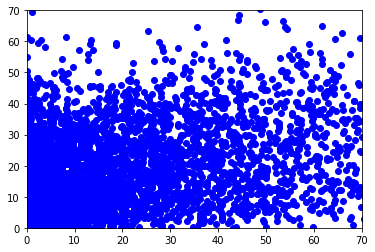

CPU times: user 20min 23s, sys: 1min 8s, total: 21min 31s
Wall time: 11min 33s


In [21]:
%%time
params =   {
    'learning_rate': 0.01, 
    'gamma' : 0.5, 
    'min_child_weight' : 1,
    'nthread' : 15,
    'max_depth' : 30,
    'subsample' : 0.9,
    'eval_metric' : 'rmse',
    'colsample_bytree' : 0.8, 
    'num_boost_round' : 500,
    'n_estimators': 200,
    'max_leaves': 300,
    'objective': 'reg:linear'}
model_ta = xgb.XGBRegressor(learning_rate= 0.01, 
      gamma = 0.5, 
      min_child_weight = 1,
      nthread = 15,
      max_depth= 30,
      subsample= 0.9,
      eval_metric= 'rmse',
      colsample_bytree= 0.8, 
      num_boost_round= 500,
      n_estimators=200,
      max_leaves=30)
 
select_ta = SelectFromModel(model_ta, threshold="mean")
select_ta.fit(X_train_ta,y_train_ta)
 
X_train_s1_ta = select_ta.transform(X_train_ta)
X_test_s1_ta = select_ta.transform(X_test_ta)
X_valid_s1_ta = select_ta.transform(X_valid_ta)
print(X_train_s1_ta.shape)

VALID = True
if VALID == True:

  tr_data_ta = xgb.DMatrix(X_train_s1_ta, y_train_ta)
  va_data_ta = xgb.DMatrix(X_valid_s1_ta, y_valid_ta)

  watchlist = [(tr_data_ta, 'train'), (va_data_ta, 'valid')]

  model_ta = xgb.train(params, tr_data_ta, 500,  watchlist,maximize=False, 
                      early_stopping_rounds = 30, verbose_eval=50)
y_pred_ta = model_ta.predict(xgb.DMatrix(X_test_s1_ta))
ta_real = y_test_ta.reset_index()
ta_real['total_spent_pred'] = y_pred_ta
linreg_RMSEk_ta = np.sqrt(mse(ta_real['total_spent_pred'], ta_real['w_total_spent']))
print(linreg_RMSEk_ta)
#plt.figure(figsize=(15,10))

plt.plot(ta_real['w_total_spent'],ta_real['total_spent_pred'],'bo')
plt.axis([0, 70, 0, 70]); plt.show()
# 0.1 mean 5.3968 rmse , 변수 398개 (64포함)
# 0.5 mean rmse 5.3833, 변수 370개 (64포함)
# 0.5 mean rmse 3.71 (64개 미포함,200개) 3.70 : child 1, 3.727: child 1, gamma 0, 3.75: gamma 0.5 하지만 분포는 낮은 값으로 압축됨(값은 안나옴)
# 0.5 mean rmse3.7105 (64개 미포함,1000개)

5.403059093042462


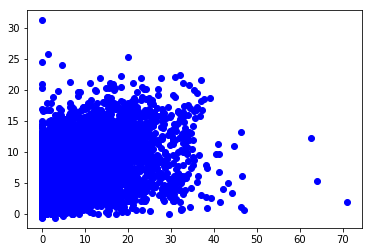

In [19]:
y_pred_ta = model_ta.predict(xgb.DMatrix(X_test_ta))
ta_real = y_test_ta.reset_index()
ta_real['total_spent_pred'] = y_pred_ta
linreg_RMSEk_ta = np.sqrt(mse(ta_real['total_spent_pred'], ta_real['total_spent']))
print(linreg_RMSEk_ta)
#plt.figure(figsize=(15,10))

plt.plot(ta_real['total_spent'],ta_real['total_spent_pred'],'bo')
#plt.axis([0, 70, 0, 70]); plt.show()


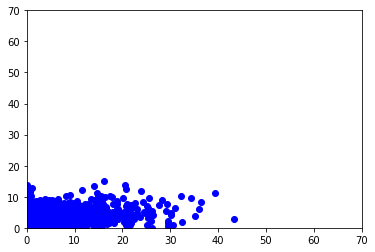

In [239]:
plt.plot(ta_real['total_spent'],ta_real['total_spent_pred'],'bo')
plt.axis([0, 70, 0, 70]); plt.show()

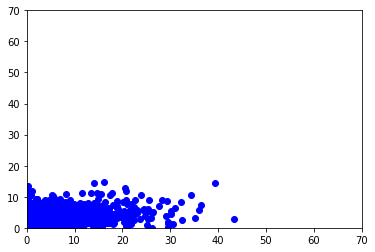

In [232]:
plt.plot(ta_real['total_spent'],ta_real['total_spent_pred'],'bo')
plt.axis([0, 70, 0, 70]); plt.show()


In [9]:
from sklearn.model_selection import train_test_split

X_train_ta, X_test_ta, y_train_ta, y_test_ta = train_test_split(data_63[data_63.columns[1:]], data_63_lbl['total_spent'], test_size=0.3, random_state=42)
#X_train_ta, X_valid_ta, y_train_ta, y_valid_ta = train_test_split(X_train_ta, y_train_ta, test_size=0.25, random_state=42)

X_train_ta.shape, X_test_ta.shape,y_train_ta.shape, y_test_ta.shape

((12602, 400), (5402, 400), (12602,), (5402,))

In [0]:
%%time
from sklearn.model_selection import KFold

threshholds = ["2.5*mean","2.3*mean","2*mean", "1.5*mean","1.8*mean","1.7*mean","1.5*mean","1.2*mean", "mean","0.9*mean", "0.7*mean", "0.6*mean" , "0.4*mean", "0.3*mean","0.2*mean", "0.1*mean", "0.05*mean"]

for thresh in threshholds:
  model_ta = xgb.XGBRegressor(learning_rate= 0.02, 
      gamma = 0.3, 
      min_child_weight = 3,
      nthread = 15,
      max_depth= 30,
      subsample= 0.9,
      eval_metric= 'rmse',
      colsample_bytree= 0.8, 
      n_estimators=500,
      max_leaves=300)

  select_ta = SelectFromModel(model_ta, threshold=thresh)
  select_ta.fit(X_train_ta,y_train_ta)

  X_train_s1_ta = select_ta.transform(X_train_ta)
  X_test_s1_ta = select_ta.transform(X_test_ta)


  X = X_train_s1_ta
  y = y_train_ta
  y= y.reset_index(drop=True)


  kf = KFold(n_splits=5, random_state=42, shuffle=True)
  kf.get_n_splits(X)

  print(kf)  

  KFold(n_splits=5, random_state=42, shuffle=True)
  for train_index, test_index in kf.split(X):
      print("TRAIN:", train_index, "TEST:", test_index)
      X_train, X_test = X[train_index], X[test_index]
      y_train, y_test = y[train_index], y[test_index]

  dtrain = xgb.DMatrix(X_train, label=y_train)
  dvalid = xgb.DMatrix(X_test, label=y_test)
  dtest = xgb.DMatrix(X_test_s1_ta)
  watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

  # Try different parameters! My favorite is random search :)
  xgb_pars = {'learning_rate': 0.02, 
      'gamma' : 0.5, 
      'min_child_weight' : 1,
      'nthread' : 15,
      'max_depth' : 30,
      'subsample' : 0.9,
      'eval_metric' : 'rmse',
      'colsample_bytree' : 0.8, 
      'num_boost_round' : 500,
      'n_estimators': 200,
      'max_leaves': 300,
      'objective': 'reg:squarederror'}
  model = xgb.train(params, dtrain, 500,  watchlist,maximize=False, 
                        early_stopping_rounds = 30, verbose_eval=50)

  y_pred = model.predict(dtest)
  real = y_test_ta.reset_index()
  real['total_spent_pred'] = y_pred
  linreg_RMSEk = np.sqrt(mse(real['total_spent_pred'], real['total_spent']))
  print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, X_train_s1_ta.shape[1], linreg_RMSEk))
  #plt.figure(figsize=(15,10))

  #plt.plot(real['total_spent'],real['total_spent_pred'],'bo')
  #plt.axis([0, 70, 0, 70]); plt.show()

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:15:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
KFold(n_splits=5, random_state=42, shuffle=True)
TRAIN: [    1     2     4 ... 12598 12599 12601] TEST: [    0     3     8 ... 12593 12595 12600]
TRAIN: [    0     1     2 ... 12598 12599 12600] TEST: [   10    12    20 ... 12586 12597 12601]
TRAIN: [    0     1     2 ... 12599 12600 12601] TEST: [   15    26    27 ... 12581 12591 12594]
TRAIN: [    0     1     3 ... 12599 12600 12601] TEST: [    2     6     7 ... 12592 12596 12598]
TRAIN: [    0     2     3 ... 12598 12600 12601] TEST: [    1     4     5 ... 12588 12589 12599]
[0]	train-rmse:4.51394	valid-rmse:4.65037
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 30 rounds.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[50]	train-rmse:3.12516	valid-rmse:4.26585
[100]	train-rmse:2.4738	valid-rmse:4.2611
Stopping. Best iteration:
[76]	train-rmse:2.72981	valid-rmse:4.24119

4.056211396104081
[17:24:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


KFold(n_splits=5, random_state=42, shuffle=True)
TRAIN: [    1     2     4 ... 12598 12599 12601] TEST: [    0     3     8 ... 12593 12595 12600]
TRAIN: [    0     1     2 ... 12598 12599 12600] TEST: [   10    12    20 ... 12586 12597 12601]
TRAIN: [    0     1     2 ... 12599 12600 12601] TEST: [   15    26    27 ... 12581 12591 12594]
TRAIN: [    0     1     3 ... 12599 12600 12601] TEST: [    2     6     7 ... 12592 12596 12598]
TRAIN: [    0     2     3 ... 12598 12600 12601] TEST: [    1     4     5 ... 12588 12589 12599]
[0]	train-rmse:4.50805	valid-rmse:4.65109
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 30 rounds.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[50]	train-rmse:2.74169	valid-rmse:4.25319
[100]	train-rmse:1.82625	valid-rmse:4.21872
Stopping. Best iteration:
[82]	train-rmse:2.08903	valid-rmse:4.21677

3.8987274493643995
[17:34:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


KFold(n_splits=5, random_state=42, shuffle=True)
TRAIN: [    1     2     4 ... 12598 12599 12601] TEST: [    0     3     8 ... 12593 12595 12600]
TRAIN: [    0     1     2 ... 12598 12599 12600] TEST: [   10    12    20 ... 12586 12597 12601]
TRAIN: [    0     1     2 ... 12599 12600 12601] TEST: [   15    26    27 ... 12581 12591 12594]
TRAIN: [    0     1     3 ... 12599 12600 12601] TEST: [    2     6     7 ... 12592 12596 12598]
TRAIN: [    0     2     3 ... 12598 12600 12601] TEST: [    1     4     5 ... 12588 12589 12599]
[0]	train-rmse:4.50103	valid-rmse:4.64784
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 30 rounds.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[50]	train-rmse:2.60036	valid-rmse:4.22702
[100]	train-rmse:1.63947	valid-rmse:4.17078
Stopping. Best iteration:
[103]	train-rmse:1.60075	valid-rmse:4.16944

3.8435555846181506
[17:43:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


KFold(n_splits=5, random_state=42, shuffle=True)
TRAIN: [    1     2     4 ... 12598 12599 12601] TEST: [    0     3     8 ... 12593 12595 12600]
TRAIN: [    0     1     2 ... 12598 12599 12600] TEST: [   10    12    20 ... 12586 12597 12601]
TRAIN: [    0     1     2 ... 12599 12600 12601] TEST: [   15    26    27 ... 12581 12591 12594]
TRAIN: [    0     1     3 ... 12599 12600 12601] TEST: [    2     6     7 ... 12592 12596 12598]
TRAIN: [    0     2     3 ... 12598 12600 12601] TEST: [    1     4     5 ... 12588 12589 12599]
[0]	train-rmse:4.49872	valid-rmse:4.65025
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 30 rounds.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[50]	train-rmse:2.4542	valid-rmse:4.18252
[100]	train-rmse:1.41505	valid-rmse:4.11734
Stopping. Best iteration:
[111]	train-rmse:1.26726	valid-rmse:4.11373

3.8052002398011857
[17:53:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


KFold(n_splits=5, random_state=42, shuffle=True)
TRAIN: [    1     2     4 ... 12598 12599 12601] TEST: [    0     3     8 ... 12593 12595 12600]
TRAIN: [    0     1     2 ... 12598 12599 12600] TEST: [   10    12    20 ... 12586 12597 12601]
TRAIN: [    0     1     2 ... 12599 12600 12601] TEST: [   15    26    27 ... 12581 12591 12594]
TRAIN: [    0     1     3 ... 12599 12600 12601] TEST: [    2     6     7 ... 12592 12596 12598]
TRAIN: [    0     2     3 ... 12598 12600 12601] TEST: [    1     4     5 ... 12588 12589 12599]
[0]	train-rmse:4.49869	valid-rmse:4.65147
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 30 rounds.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[50]	train-rmse:2.47713	valid-rmse:4.20779
[100]	train-rmse:1.44917	valid-rmse:4.15121
Stopping. Best iteration:
[107]	train-rmse:1.35225	valid-rmse:4.15067

3.8264368885333404
[18:02:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


KFold(n_splits=5, random_state=42, shuffle=True)
TRAIN: [    1     2     4 ... 12598 12599 12601] TEST: [    0     3     8 ... 12593 12595 12600]
TRAIN: [    0     1     2 ... 12598 12599 12600] TEST: [   10    12    20 ... 12586 12597 12601]
TRAIN: [    0     1     2 ... 12599 12600 12601] TEST: [   15    26    27 ... 12581 12591 12594]
TRAIN: [    0     1     3 ... 12599 12600 12601] TEST: [    2     6     7 ... 12592 12596 12598]
TRAIN: [    0     2     3 ... 12598 12600 12601] TEST: [    1     4     5 ... 12588 12589 12599]
[0]	train-rmse:4.49824	valid-rmse:4.65028
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 30 rounds.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[50]	train-rmse:2.47349	valid-rmse:4.20337
[100]	train-rmse:1.44352	valid-rmse:4.1311
Stopping. Best iteration:
[100]	train-rmse:1.44352	valid-rmse:4.1311

3.822366275228876
[18:12:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


KFold(n_splits=5, random_state=42, shuffle=True)
TRAIN: [    1     2     4 ... 12598 12599 12601] TEST: [    0     3     8 ... 12593 12595 12600]
TRAIN: [    0     1     2 ... 12598 12599 12600] TEST: [   10    12    20 ... 12586 12597 12601]
TRAIN: [    0     1     2 ... 12599 12600 12601] TEST: [   15    26    27 ... 12581 12591 12594]
TRAIN: [    0     1     3 ... 12599 12600 12601] TEST: [    2     6     7 ... 12592 12596 12598]
TRAIN: [    0     2     3 ... 12598 12600 12601] TEST: [    1     4     5 ... 12588 12589 12599]
[0]	train-rmse:4.49872	valid-rmse:4.65025
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 30 rounds.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[50]	train-rmse:2.4542	valid-rmse:4.18252
[100]	train-rmse:1.41505	valid-rmse:4.11734
Stopping. Best iteration:
[111]	train-rmse:1.26726	valid-rmse:4.11373

3.8052002398011857
[18:22:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


KFold(n_splits=5, random_state=42, shuffle=True)
TRAIN: [    1     2     4 ... 12598 12599 12601] TEST: [    0     3     8 ... 12593 12595 12600]
TRAIN: [    0     1     2 ... 12598 12599 12600] TEST: [   10    12    20 ... 12586 12597 12601]
TRAIN: [    0     1     2 ... 12599 12600 12601] TEST: [   15    26    27 ... 12581 12591 12594]
TRAIN: [    0     1     3 ... 12599 12600 12601] TEST: [    2     6     7 ... 12592 12596 12598]
TRAIN: [    0     2     3 ... 12598 12600 12601] TEST: [    1     4     5 ... 12588 12589 12599]


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-rmse:4.49749	valid-rmse:4.64975
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 30 rounds.
[50]	train-rmse:2.41586	valid-rmse:4.18191
[100]	train-rmse:1.35688	valid-rmse:4.11015
Stopping. Best iteration:
[119]	train-rmse:1.10334	valid-rmse:4.10955

3.803717216100865
[18:31:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


# 일평균 결제량 0.55 이상인 유저 일평균결제량 예측 (생존기간 1인 유저의 분포를 바탕으로 선정)

고과금 유저 결제량 예측을 위한 모델

전체 844명이고 높은 결제량을 가진 유저는 매우 적은 편이랑 오버샘플링 필요

In [0]:
data_lbl['spent_1'] = np.where(data_lbl['amount_spent_y']>=0.55, 1, 0) # 일평균 결제량이 1 이상이면 1, 아니면 0

In [0]:
data_055 = data_lbl[data_lbl['amount_spent_y']>=0.55].drop(['Unnamed: 0', 'survival_time', 'amount_spent_y', 'secession',
       'total_spent', 'spent_1'], axis=1)

In [29]:
from sklearn.model_selection import train_test_split

X_train_ta, X_test_ta, y_train_ta, y_test_ta = train_test_split(data_055[data_055.columns[1:]], data_lbl[data_lbl['amount_spent_y']>=0.55]['amount_spent_y'], test_size=0.2, random_state=42)
#X_train_ta, X_valid_ta, y_train_ta, y_valid_ta = train_test_split(X_train_ta, y_train_ta, test_size=0.25, random_state=42)

X_train_ta.shape, X_test_ta.shape,y_train_ta.shape, y_test_ta.shape

((844, 400), (212, 400), (844,), (212,))

In [20]:
%%time
# 일평균 결제량 1 이상인 유저 회귀 분석
from sklearn.model_selection import KFold

threshholds = ['0.7*mean', "0.8*mean","0.95*mean","mean", "1.1*mean","1.2*mean", "1.3*mean" , "1.4*mean", "1.5*mean","1.6*mean", "1.7*mean", "1.8*mean","1.9*mean",'2*mean','2.1*mean','2.2*mean']

for thresh in threshholds:
  model_ta = xgb.XGBRegressor(learning_rate= 0.02, 
      gamma = 0.3, 
      min_child_weight = 3,
      nthread = 15,
      max_depth= 30,
      subsample= 0.9,
      eval_metric= 'rmse',
      colsample_bytree= 0.8, 
      n_estimators=500,
      max_leaves=300)

  select_ta = SelectFromModel(model_ta, threshold=thresh)
  select_ta.fit(X_train_ta,y_train_ta)

  X_train_s1_ta = select_ta.transform(X_train_ta)
  X_test_s1_ta = select_ta.transform(X_test_ta)
  
  print("X_train_s1.shape : {}".format(X_train_s1_ta.shape))
  

  X = X_train_s1_ta
  y = y_train_ta
  y= y.reset_index(drop=True)


  kf = KFold(n_splits=5, random_state=42, shuffle=True)
  kf.get_n_splits(X)

  print(kf)  

  KFold(n_splits=5, random_state=42, shuffle=True)
  for train_index, test_index in kf.split(X):
      #print("TRAIN:", train_index, "TEST:", test_index)
      X_train, X_test = X[train_index], X[test_index]
      y_train, y_test = y[train_index], y[test_index]

  dtrain = xgb.DMatrix(X_train, label=y_train)
  dvalid = xgb.DMatrix(X_test, label=y_test)
  dtest = xgb.DMatrix(X_test_s1_ta)
  watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

  # Try different parameters! My favorite is random search :)
  xgb_pars = {'learning_rate': 0.02, 
      'gamma' : 0.5, 
      'min_child_weight' : 1,
      'nthread' : 15,
      'max_depth' : 30,
      'subsample' : 0.9,
      'eval_metric' : 'rmse',
      'colsample_bytree' : 0.8, 
      'num_boost_round' : 500,
      'n_estimators': 500,
      'max_leaves': 300,
      'objective': 'reg:squarederror'}
  model = xgb.train(xgb_pars, dtrain, 500,  watchlist,maximize=False, 
                        early_stopping_rounds = 30, verbose_eval=50)

  y_pred = model.predict(dtest)
  real = y_test_ta.reset_index()
  real['total_spent_pred'] = y_pred
  linreg_RMSEk = np.sqrt(mse(real['total_spent_pred'], real['amount_spent_y']))
  print("Thresh=%s, n=%d,  rmse: %3f%%" % (thresh, X_train_s1_ta.shape[1], linreg_RMSEk))

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:50:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
X_train_s1.shape : (844, 172)
KFold(n_splits=5, random_state=42, shuffle=True)
[0]	train-rmse:3.65668	valid-rmse:3.83158
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 30 rounds.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[50]	train-rmse:1.91962	valid-rmse:3.45512
Stopping. Best iteration:
[61]	train-rmse:1.67149	valid-rmse:3.44986

Thresh=0.8*mean, n=172,  rmse: 4.828097%
[17:51:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


X_train_s1.shape : (844, 150)
KFold(n_splits=5, random_state=42, shuffle=True)
[0]	train-rmse:3.65644	valid-rmse:3.83801
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 30 rounds.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[50]	train-rmse:1.91182	valid-rmse:3.45528
Stopping. Best iteration:
[58]	train-rmse:1.72596	valid-rmse:3.44346

Thresh=0.95*mean, n=150,  rmse: 4.842675%
[17:51:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


X_train_s1.shape : (844, 146)
KFold(n_splits=5, random_state=42, shuffle=True)
[0]	train-rmse:3.65468	valid-rmse:3.84672
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 30 rounds.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[50]	train-rmse:1.90809	valid-rmse:3.50259
Stopping. Best iteration:
[62]	train-rmse:1.64174	valid-rmse:3.48648

Thresh=mean, n=146,  rmse: 4.886463%
[17:52:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


X_train_s1.shape : (844, 127)
KFold(n_splits=5, random_state=42, shuffle=True)
[0]	train-rmse:3.65535	valid-rmse:3.83869
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 30 rounds.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[50]	train-rmse:1.90765	valid-rmse:3.50143
Stopping. Best iteration:
[68]	train-rmse:1.52684	valid-rmse:3.48366

Thresh=1.1*mean, n=127,  rmse: 4.752186%
[17:53:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


X_train_s1.shape : (844, 114)
KFold(n_splits=5, random_state=42, shuffle=True)
[0]	train-rmse:3.6538	valid-rmse:3.84429
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 30 rounds.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[50]	train-rmse:1.90976	valid-rmse:3.46534
Stopping. Best iteration:
[67]	train-rmse:1.55042	valid-rmse:3.45043

Thresh=1.2*mean, n=114,  rmse: 4.740926%
[17:53:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


X_train_s1.shape : (844, 99)
KFold(n_splits=5, random_state=42, shuffle=True)
[0]	train-rmse:3.65672	valid-rmse:3.83666
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 30 rounds.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[50]	train-rmse:1.90895	valid-rmse:3.42677
Stopping. Best iteration:
[67]	train-rmse:1.54432	valid-rmse:3.40767

Thresh=1.3*mean, n=99,  rmse: 4.781824%
[17:54:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


X_train_s1.shape : (844, 92)
KFold(n_splits=5, random_state=42, shuffle=True)
[0]	train-rmse:3.65536	valid-rmse:3.83549
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 30 rounds.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[50]	train-rmse:1.91084	valid-rmse:3.39173
[100]	train-rmse:1.05536	valid-rmse:3.37708
Stopping. Best iteration:
[84]	train-rmse:1.26912	valid-rmse:3.36483

Thresh=1.4*mean, n=92,  rmse: 4.704384%
[17:55:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


X_train_s1.shape : (844, 83)
KFold(n_splits=5, random_state=42, shuffle=True)
[0]	train-rmse:3.65645	valid-rmse:3.82993
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 30 rounds.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[50]	train-rmse:1.91285	valid-rmse:3.41019
[100]	train-rmse:1.05563	valid-rmse:3.3839
Stopping. Best iteration:
[84]	train-rmse:1.26919	valid-rmse:3.37515

Thresh=1.5*mean, n=83,  rmse: 4.717115%
[17:55:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


X_train_s1.shape : (844, 72)
KFold(n_splits=5, random_state=42, shuffle=True)
[0]	train-rmse:3.65499	valid-rmse:3.83879
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 30 rounds.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[50]	train-rmse:1.91732	valid-rmse:3.4217
[100]	train-rmse:1.06929	valid-rmse:3.368
Stopping. Best iteration:
[113]	train-rmse:0.929755	valid-rmse:3.36228

Thresh=1.6*mean, n=72,  rmse: 4.661959%
[17:56:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


X_train_s1.shape : (844, 66)
KFold(n_splits=5, random_state=42, shuffle=True)
[0]	train-rmse:3.65664	valid-rmse:3.83865
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 30 rounds.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[50]	train-rmse:1.91975	valid-rmse:3.43243
Stopping. Best iteration:
[68]	train-rmse:1.54337	valid-rmse:3.39157

Thresh=1.7*mean, n=66,  rmse: 4.725335%
[17:57:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


X_train_s1.shape : (844, 58)
KFold(n_splits=5, random_state=42, shuffle=True)
[0]	train-rmse:3.6573	valid-rmse:3.83768
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 30 rounds.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[50]	train-rmse:1.91828	valid-rmse:3.43323
[100]	train-rmse:1.0687	valid-rmse:3.38934
Stopping. Best iteration:
[92]	train-rmse:1.17079	valid-rmse:3.38015

Thresh=1.8*mean, n=58,  rmse: 4.676525%
CPU times: user 11min 11s, sys: 2min 11s, total: 13min 22s
Wall time: 7min 22s


4.676525425231633


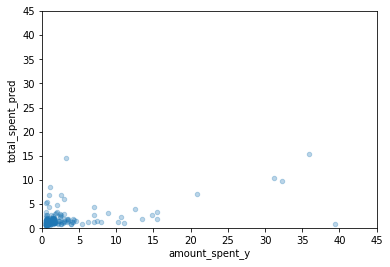

In [25]:
#linreg_RMSEk = np.sqrt(mse(real['total_spent_pred'], real['amount_spent_y']))
print(linreg_RMSEk)
real.plot(kind='scatter',x='amount_spent_y',y= 'total_spent_pred',alpha=0.3)
plt.axis([0, 45, 0, 45]); plt.show()

# 데이터에 가중치를 적용해서 고과금 유저 정확도 높이기

In [1]:
from sklearn.model_selection import train_test_split
data_lbl['w_amount_spent'] = data_lbl['amount_spent_y'] * np.log(data_lbl['amount_spent_y']+1) *5


X_train_ta, X_test_ta, y_train_ta, y_test_ta = train_test_split(data[data.columns[1:]], data_lbl['w_amount_spent'], test_size=0.3, random_state=42)
#X_train_ta, X_valid_ta, y_train_ta, y_valid_ta = train_test_split(X_train_ta, y_train_ta, test_size=0.25, random_state=42)

X_train_ta.shape, X_test_ta.shape,y_train_ta.shape, y_test_ta.shape

NameError: ignored

In [0]:
ind = data_lbl.reset_index()

In [0]:
%%time
# 일평균 결제량 가중치 로그*5 회귀 분석
from sklearn.model_selection import KFold

threshholds = ['0.7*mean', "0.8*mean","0.95*mean","mean", "1.1*mean","1.2*mean", "1.3*mean" , "1.4*mean", "1.5*mean","1.6*mean", "1.7*mean", "1.8*mean","1.9*mean",'2*mean','2.1*mean','2.2*mean']

for thresh in threshholds:
  model_ta = xgb.XGBRegressor(learning_rate= 0.02, 
      gamma = 0.3, 
      min_child_weight = 3,
      nthread = 15,
      max_depth= 30,
      subsample= 0.9,
      eval_metric= 'rmse',
      colsample_bytree= 0.8, 
      n_estimators=500,
      max_leaves=300)

  select_ta = SelectFromModel(model_ta, threshold=thresh)
  select_ta.fit(X_train_ta,y_train_ta)

  X_train_s1_ta = select_ta.transform(X_train_ta)
  X_test_s1_ta = select_ta.transform(X_test_ta)
  
  print("X_train_s1.shape : {}".format(X_train_s1_ta.shape))
  

  X = X_train_s1_ta
  y = y_train_ta
  y= y.reset_index(drop=True)


  kf = KFold(n_splits=5, random_state=42, shuffle=True)
  kf.get_n_splits(X)

  print(kf)  

  KFold(n_splits=5, random_state=42, shuffle=True)
  for train_index, test_index in kf.split(X):
      #print("TRAIN:", train_index, "TEST:", test_index)
      X_train, X_test = X[train_index], X[test_index]
      y_train, y_test = y[train_index], y[test_index]

  dtrain = xgb.DMatrix(X_train, label=y_train)
  dvalid = xgb.DMatrix(X_test, label=y_test)
  dtest = xgb.DMatrix(X_test_s1_ta)
  watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

  # Try different parameters! My favorite is random search :)
  xgb_pars = {'learning_rate': 0.02, 
      'gamma' : 0.3, 
      'min_child_weight' : 3,
      'nthread' : 15,
      'max_depth' : 30,
      'subsample' : 0.9,
      'eval_metric' : 'rmse',
      'colsample_bytree' : 0.8, 
      'num_boost_round' : 500,
      'n_estimators': 500,
      'max_leaves': 300,
      'objective': 'reg:squarederror'}
  model = xgb.train(xgb_pars, dtrain, 500,  watchlist,maximize=False, 
                        early_stopping_rounds = 30, verbose_eval=50)

  y_pred = model.predict(dtest)
  real = y_test_ta.reset_index()
  real['amount_spent_pred'] = y_pred
  linreg_RMSEk_w = np.sqrt(mse(real['amount_spent_pred'], real['w_amount_spent']))
  spent_compare = pd.merge(ind[['index','amount_spent_y']], real, on ='index', how='right')
  linreg_RMSEk = np.sqrt(mse(spent_compare['amount_spent_pred'], spent_compare['amount_spent_y']))

  print("가중치 적용 라벨 rmse: ",linreg_RMSEk_w)
  print("Thresh=%s, n=%d,  rmse: %3f" % (thresh, X_train_s1_ta.shape[1], linreg_RMSEk))

In [0]:
%%time
# 일평균 결제량 가중치 로그*1.5 회귀 분석
from sklearn.model_selection import KFold

threshholds = ['0.7*mean', "0.8*mean","0.95*mean","mean", "1.1*mean","1.2*mean", "1.3*mean" , "1.4*mean", "1.5*mean","1.6*mean", "1.7*mean", "1.8*mean","1.9*mean",'2*mean','2.1*mean','2.2*mean']

for thresh in threshholds:
  model_ta = xgb.XGBRegressor(learning_rate= 0.02, 
      gamma = 0.3, 
      min_child_weight = 3,
      nthread = 15,
      max_depth= 30,
      subsample= 0.9,
      eval_metric= 'rmse',
      colsample_bytree= 0.8, 
      n_estimators=500,
      max_leaves=300)

  select_ta = SelectFromModel(model_ta, threshold=thresh)
  select_ta.fit(X_train_ta,y_train_ta)

  X_train_s1_ta = select_ta.transform(X_train_ta)
  X_test_s1_ta = select_ta.transform(X_test_ta)
  
  print("X_train_s1.shape : {}".format(X_train_s1_ta.shape))
  

  X = X_train_s1_ta
  y = y_train_ta
  y= y.reset_index(drop=True)


  kf = KFold(n_splits=5, random_state=42, shuffle=True)
  kf.get_n_splits(X)

  print(kf)  

  KFold(n_splits=5, random_state=42, shuffle=True)
  for train_index, test_index in kf.split(X):
      #print("TRAIN:", train_index, "TEST:", test_index)
      X_train, X_test = X[train_index], X[test_index]
      y_train, y_test = y[train_index], y[test_index]

  dtrain = xgb.DMatrix(X_train, label=y_train)
  dvalid = xgb.DMatrix(X_test, label=y_test)
  dtest = xgb.DMatrix(X_test_s1_ta)
  watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

  # Try different parameters! My favorite is random search :)
  xgb_pars = {'learning_rate': 0.02, 
      'gamma' : 0.3, 
      'min_child_weight' : 3,
      'nthread' : 15,
      'max_depth' : 30,
      'subsample' : 0.9,
      'eval_metric' : 'rmse',
      'colsample_bytree' : 0.8, 
      'num_boost_round' : 500,
      'n_estimators': 500,
      'max_leaves': 300,
      'objective': 'reg:squarederror'}
  model = xgb.train(xgb_pars, dtrain, 500,  watchlist,maximize=False, 
                        early_stopping_rounds = 30, verbose_eval=50)

  y_pred = model.predict(dtest)
  real = y_test_ta.reset_index()
  real['amount_spent_pred'] = y_pred
  linreg_RMSEk_w = np.sqrt(mse(real['amount_spent_pred'], real['w_amount_spent']))
  spent_compare = pd.merge(ind[['index','amount_spent_y']], real, on ='index', how='right')
  linreg_RMSEk = np.sqrt(mse(spent_compare['amount_spent_pred'], spent_compare['amount_spent_y']))

  print("가중치 적용 라벨 rmse: ",linreg_RMSEk_w)
  print("Thresh=%s, n=%d,  rmse: %3f" % (thresh, X_train_s1_ta.shape[1], linreg_RMSEk))

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[06:34:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
X_train_s1.shape : (28000, 152)
KFold(n_splits=5, random_state=42, shuffle=True)


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-rmse:3.33246	valid-rmse:3.00136
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 30 rounds.
[50]	train-rmse:2.40813	valid-rmse:2.96701
Stopping. Best iteration:
[30]	train-rmse:2.69278	valid-rmse:2.94841

가중치 적용 라벨 rmse:  2.915210903387555
Thresh=0.7*mean, n=152,  rmse: 0.995219
[06:50:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


X_train_s1.shape : (28000, 133)
KFold(n_splits=5, random_state=42, shuffle=True)


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-rmse:3.33393	valid-rmse:3.00598
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 30 rounds.
[50]	train-rmse:2.41316	valid-rmse:2.95889
Stopping. Best iteration:
[47]	train-rmse:2.45957	valid-rmse:2.95534

가중치 적용 라벨 rmse:  2.926511932152856
Thresh=0.8*mean, n=133,  rmse: 1.027061
[07:07:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


X_train_s1.shape : (28000, 112)
KFold(n_splits=5, random_state=42, shuffle=True)


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-rmse:3.33808	valid-rmse:3.00596
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 30 rounds.
[50]	train-rmse:2.39613	valid-rmse:2.96522
Stopping. Best iteration:
[29]	train-rmse:2.71668	valid-rmse:2.95864

가중치 적용 라벨 rmse:  2.869246437700411
Thresh=0.95*mean, n=112,  rmse: 0.933477
[07:23:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


X_train_s1.shape : (28000, 109)
KFold(n_splits=5, random_state=42, shuffle=True)


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-rmse:3.33947	valid-rmse:3.00598
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 30 rounds.
[50]	train-rmse:2.39626	valid-rmse:2.96291
Stopping. Best iteration:
[29]	train-rmse:2.71857	valid-rmse:2.9569

가중치 적용 라벨 rmse:  2.896465697157554
Thresh=mean, n=109,  rmse: 0.945823
[07:39:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


X_train_s1.shape : (28000, 99)
KFold(n_splits=5, random_state=42, shuffle=True)


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-rmse:3.33507	valid-rmse:3.00517
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 30 rounds.
[50]	train-rmse:2.4001	valid-rmse:2.94966
Stopping. Best iteration:
[42]	train-rmse:2.51843	valid-rmse:2.94225

가중치 적용 라벨 rmse:  2.8981437374704186
Thresh=1.1*mean, n=99,  rmse: 0.986312
[07:55:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


X_train_s1.shape : (28000, 91)
KFold(n_splits=5, random_state=42, shuffle=True)


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-rmse:3.34021	valid-rmse:3.0032
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 30 rounds.
[50]	train-rmse:2.40702	valid-rmse:2.95248
Stopping. Best iteration:
[29]	train-rmse:2.71778	valid-rmse:2.94251

가중치 적용 라벨 rmse:  2.910920342629887
Thresh=1.2*mean, n=91,  rmse: 0.963021
[08:11:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


X_train_s1.shape : (28000, 83)
KFold(n_splits=5, random_state=42, shuffle=True)


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-rmse:3.3333	valid-rmse:3.00478
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 30 rounds.
[50]	train-rmse:2.40759	valid-rmse:2.933
Stopping. Best iteration:
[30]	train-rmse:2.70207	valid-rmse:2.92385

가중치 적용 라벨 rmse:  2.900200284058256
Thresh=1.3*mean, n=83,  rmse: 1.011944
[08:27:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


X_train_s1.shape : (28000, 73)
KFold(n_splits=5, random_state=42, shuffle=True)


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-rmse:3.33356	valid-rmse:3.00526
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 30 rounds.
[50]	train-rmse:2.40842	valid-rmse:2.93576
Stopping. Best iteration:
[42]	train-rmse:2.52129	valid-rmse:2.9297

가중치 적용 라벨 rmse:  2.9336686207198226
Thresh=1.4*mean, n=73,  rmse: 1.087796
[08:43:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


X_train_s1.shape : (28000, 67)
KFold(n_splits=5, random_state=42, shuffle=True)


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-rmse:3.34036	valid-rmse:3.00477
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 30 rounds.
[50]	train-rmse:2.42596	valid-rmse:2.92728
Stopping. Best iteration:
[52]	train-rmse:2.40007	valid-rmse:2.92529

가중치 적용 라벨 rmse:  2.93081070203523
Thresh=1.5*mean, n=67,  rmse: 1.134308
[08:59:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


X_train_s1.shape : (28000, 60)
KFold(n_splits=5, random_state=42, shuffle=True)


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-rmse:3.33389	valid-rmse:3.0022
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 30 rounds.
[50]	train-rmse:2.42338	valid-rmse:2.92819
Stopping. Best iteration:
[44]	train-rmse:2.50975	valid-rmse:2.92095

가중치 적용 라벨 rmse:  2.913905078887527
Thresh=1.6*mean, n=60,  rmse: 1.052929


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[09:15:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
X_train_s1.shape : (28000, 56)
KFold(n_splits=5, random_state=42, shuffle=True)


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-rmse:3.33401	valid-rmse:3.00206
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 30 rounds.
[50]	train-rmse:2.42885	valid-rmse:2.93973
Stopping. Best iteration:
[31]	train-rmse:2.70445	valid-rmse:2.93219

가중치 적용 라벨 rmse:  2.8950439209107266
Thresh=1.7*mean, n=56,  rmse: 0.998250
[09:31:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


X_train_s1.shape : (28000, 55)
KFold(n_splits=5, random_state=42, shuffle=True)


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-rmse:3.334	valid-rmse:3.00207
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 30 rounds.
[50]	train-rmse:2.42396	valid-rmse:2.92811
Stopping. Best iteration:
[40]	train-rmse:2.56574	valid-rmse:2.9252

가중치 적용 라벨 rmse:  2.899110368748655
Thresh=1.8*mean, n=55,  rmse: 1.033287


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[09:47:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
X_train_s1.shape : (28000, 49)
KFold(n_splits=5, random_state=42, shuffle=True)


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-rmse:3.33958	valid-rmse:3.00269
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 30 rounds.
[50]	train-rmse:2.43544	valid-rmse:2.90922
Stopping. Best iteration:
[54]	train-rmse:2.38235	valid-rmse:2.90885

가중치 적용 라벨 rmse:  2.956603246929334
Thresh=1.9*mean, n=49,  rmse: 1.162542
[10:03:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[05:46:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
X_train_s1.shape : (28000, 154)
KFold(n_splits=10, random_state=None, shuffle=False)


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[05:51:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:3.16722	valid-rmse:4.24319
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[20]	train-rmse:3.06593	valid-rmse:4.21614
[40]	train-rmse:2.97423	valid-rmse:4.19296
[60]	train-rmse:2.89869	valid-rmse:4.17374
[80]	train-rmse:2.83421	valid-rmse:4.15928
[100]	train-rmse:2.77594	valid-rmse:4.14631
[120]	train-rmse:2.72503	valid-rmse:4.12728
[140]	train-rmse:2.67975	valid-rmse:4.11208
[160]	train-rmse:2.64058	valid-rmse:4.09905
[180]	train-rmse:2.60503	valid-rmse:4.0799
[200]	train-rmse:2.56987	valid-rmse:4.0627
[220]	train-rmse:2.54024	valid-rmse:4.04977
[240]	train-rmse:2.51103	valid-rmse:4.0362
[260]	train-rmse:2.48532	valid-rmse:4.02272
[280]	train-rmse:2.46171	valid-rmse:4.00932
[300]	train-rmse:2.43882	valid-rmse:4.0018
[320]	train-rmse:2.41599	valid-rms

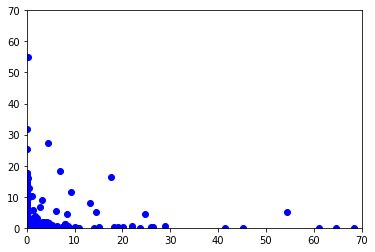

In [14]:
# 개별 테스트용 코드
model_ta = xgb.XGBRegressor(learning_rate= 0.01, 
      gamma = 0.5, 
      min_child_weight = 5,
      nthread = 15,
      max_depth= 10,
      subsample= 0.9,
      eval_metric= 'rmse',
      colsample_bytree= 0.8, 
      n_estimators=500,
      max_leaves=300)

select_ta = SelectFromModel(model_ta, threshold="0.8*mean")
select_ta.fit(X_train_ta,y_train_ta)

feature_idx_all = select_ta.get_support()
feature_name_all = data[data.columns[1:]].columns[feature_idx_all]


X_train_s1_ta = select_ta.transform(X_train_ta)
X_test_s1_ta = select_ta.transform(X_test_ta)
  
print("X_train_s1.shape : {}".format(X_train_s1_ta.shape))
  

X = X_train_s1_ta
y = y_train_ta
y= y.reset_index(drop=True)


kf = KFold(n_splits=10)
kf.get_n_splits(X)

print(kf)  

KFold(n_splits=10, random_state=None, shuffle=False)
for train_index, test_index in kf.split(X):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_test, label=y_test)
dtest = xgb.DMatrix(X_test_s1_ta)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

# Try different parameters! My favorite is random search :)
xgb_pars = {'learning_rate': 0.01, 
    'gamma' : 0.5, 
    'min_child_weight' : 10,
    'nthread' : 15,
    'max_depth' : 10,
    'subsample' : 0.9,
    'eval_metric' : 'rmse',
    'colsample_bytree' : 0.8, 
    'num_boost_round' : 500,
    'n_estimators': 500,
    'max_leaves': 300,
    'objective': 'reg:linear'}
model_ta = xgb.train(xgb_pars, dtrain, 500, watchlist, early_stopping_rounds=50,
                  maximize=False, verbose_eval=20)
#plt.figure(figsize=(15,10))
y_pred = model_ta.predict(dtest)

real = y_test_ta.reset_index()
real['amount_spent_pred'] = y_pred

linreg_RMSEk = np.sqrt(mse(real['amount_spent_pred'], real['w_amount_spent']))

print(linreg_RMSEk)
plt.plot(real['w_amount_spent'],real['amount_spent_pred'],'bo')
plt.axis([0, 70, 0, 70]); plt.show()

1.2219348088167596


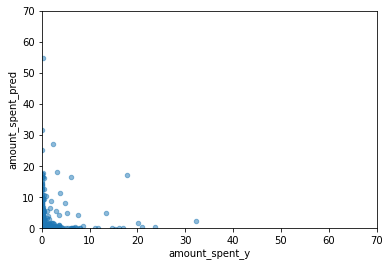

In [16]:
ind = data_lbl.reset_index()
spent_compare = pd.merge(ind[['index','amount_spent_y']], real, on ='index', how='right')
linreg_RMSEk = np.sqrt(mse(spent_compare['amount_spent_pred'], spent_compare['amount_spent_y']))

print(linreg_RMSEk)
spent_compare.plot(kind='scatter', x='amount_spent_y', y = 'amount_spent_pred',alpha= 0.5)
plt.axis([0, 70, 0, 70]); plt.show()

1.2719657487620941


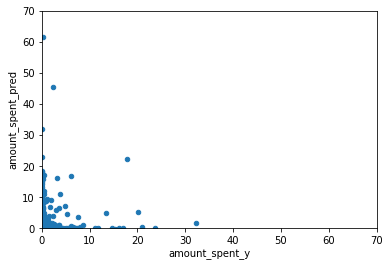

In [13]:
ind = data_lbl.reset_index()
spent_compare = pd.merge(ind[['index','amount_spent_y']], real, on ='index', how='right')
linreg_RMSEk = np.sqrt(mse(spent_compare['amount_spent_pred'], spent_compare['amount_spent_y']))

print(linreg_RMSEk)
spent_compare.plot(kind='scatter', x='amount_spent_y', y = 'amount_spent_pred',alpha= 1)
plt.axis([0, 70, 0, 70]); plt.show()

0.6869850024863747


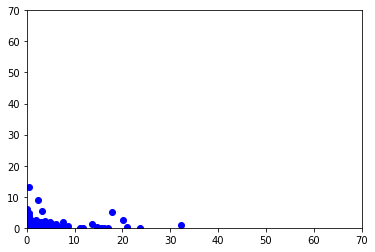

In [11]:
# 전체 유저 log 안 한 결제량 예측 plot
real = y_test_ta.reset_index()
real['amount_spent_pred'] = y_pred

linreg_RMSEk = np.sqrt(mse(real['amount_spent_pred'], real['amount_spent_y']))

print(linreg_RMSEk)
plt.plot(real['amount_spent_y'],real['amount_spent_pred'],'bo')
plt.axis([0, 70, 0, 70]); plt.show()

1.017112156192952


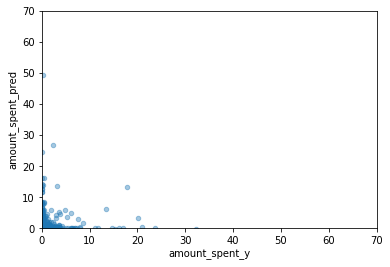

In [42]:
# 전체 유저 log 가중한 경우
ind = data_lbl.reset_index()
spent_compare = pd.merge(ind[['index','amount_spent_y']], real, on ='index', how='right')
linreg_RMSEk = np.sqrt(mse(spent_compare['amount_spent_pred'], spent_compare['amount_spent_y']))

print(linreg_RMSEk)
spent_compare.plot(kind='scatter', x='amount_spent_y', y = 'amount_spent_pred',alpha= 0.4)
plt.axis([0, 70, 0, 70]); plt.show()

1.1404480572245823


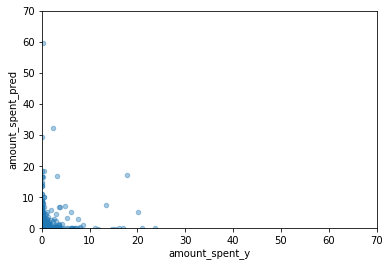

In [45]:
# 전체 유저 log*1.2 한 경우
ind = data_lbl.reset_index()
spent_compare = pd.merge(ind[['index','amount_spent_y']], real, on ='index', how='right')
linreg_RMSEk = np.sqrt(mse(spent_compare['amount_spent_pred'], spent_compare['amount_spent_y']))

print(linreg_RMSEk)
spent_compare.plot(kind='scatter', x='amount_spent_y', y = 'amount_spent_pred',alpha= 0.4)
plt.axis([0, 70, 0, 70]); plt.show()

1.3278449601541915


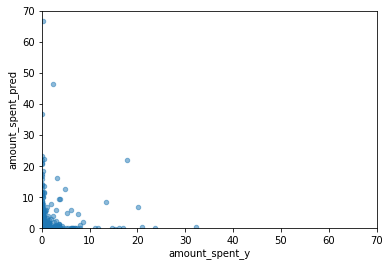

In [33]:
# 전체 유저 log*1.5 한 경우
ind = data_lbl.reset_index()
spent_compare = pd.merge(ind[['index','amount_spent_y']], real, on ='index', how='right')
linreg_RMSEk = np.sqrt(mse(spent_compare['amount_spent_pred'], spent_compare['amount_spent_y']))

print(linreg_RMSEk)
spent_compare.plot(kind='scatter', x='amount_spent_y', y = 'amount_spent_pred',alpha= 0.5)
plt.axis([0, 70, 0, 70]); plt.show()

1.443945343980221


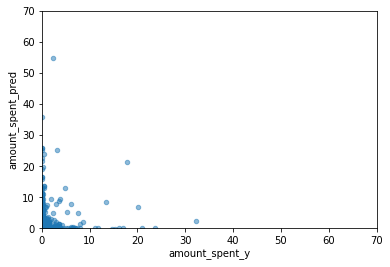

In [55]:
# 전체 유저 log*1.8 한 경우
ind = data_lbl.reset_index()
spent_compare = pd.merge(ind[['index','amount_spent_y']], real, on ='index', how='right')
linreg_RMSEk = np.sqrt(mse(spent_compare['amount_spent_pred'], spent_compare['amount_spent_y']))

print(linreg_RMSEk)
spent_compare.plot(kind='scatter', x='amount_spent_y', y = 'amount_spent_pred',alpha= 0.5)
plt.axis([0, 70, 0, 70]); plt.show()

2.026978870911104


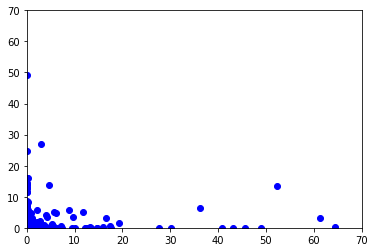

In [19]:
# log 가중치 적용된 결과와의 plot
y_pred = model_ta.predict(dtest)

real = y_test_ta.reset_index()
real['amount_spent_pred'] = y_pred

linreg_RMSEk = np.sqrt(mse(real['amount_spent_pred'], real['w_amount_spent']))

print(linreg_RMSEk)
plt.plot(real['w_amount_spent'],real['amount_spent_pred'],'bo')
plt.axis([0, 70, 0, 70]); plt.show()

---------------

In [0]:
# 전체 유저 log 안 한 결제량 예측 plot
real = y_test_ta.reset_index()
real['amount_spent_pred'] = y_pred

linreg_RMSEk = np.sqrt(mse(real['amount_spent_pred'], real['amount_spent_y']))

print(linreg_RMSEk)
plt.plot(real['amount_spent_y'],real['amount_spent_pred'],'bo')
plt.axis([0, 70, 0, 70]); plt.show()

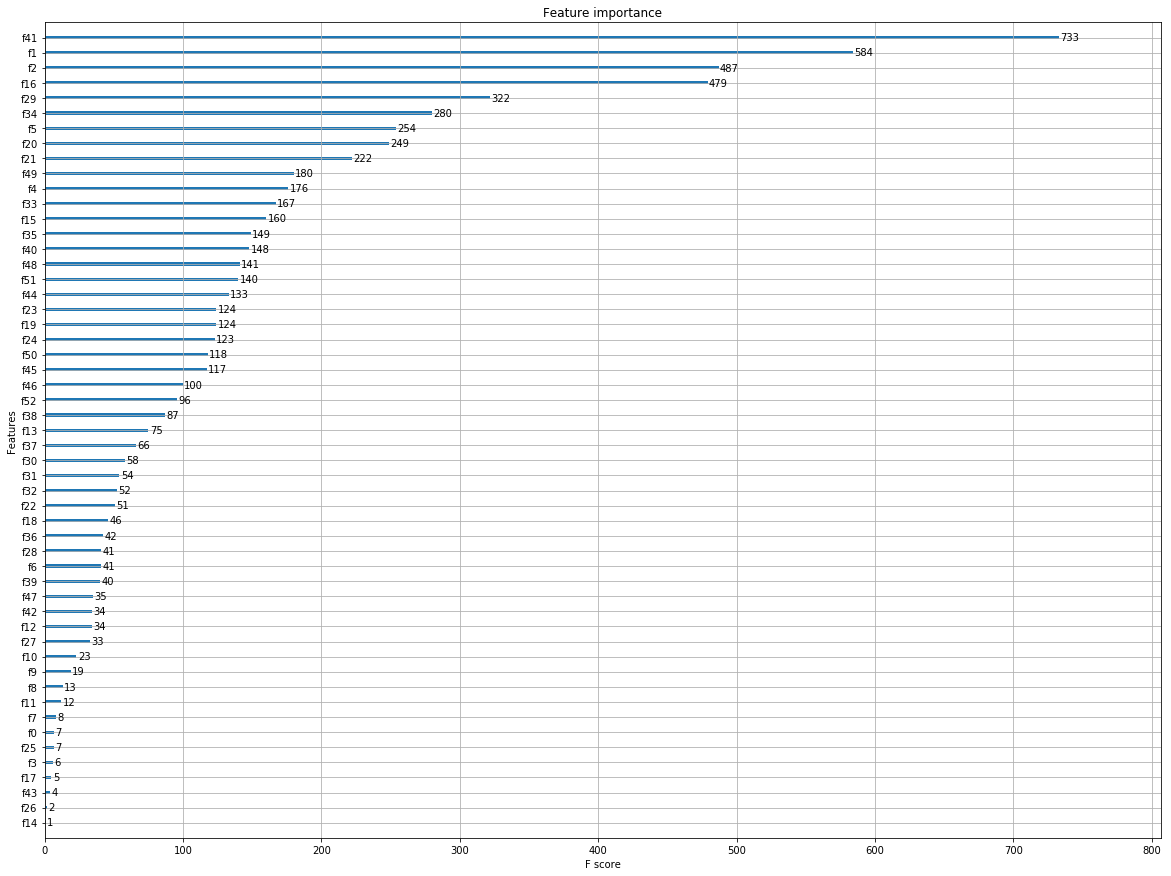

In [33]:
from xgboost import plot_importance
from matplotlib import pyplot as plt
fig, ax = plt.subplots(1,1,figsize=(20,15))
plot_importance(model_ta, ax=ax)
plt.show()

# 생존기간 10일 이하인 유저의 일평균 결제량 예측

In [0]:
data_10surv = data_lbl[data_lbl['survival_time']<=10].drop(['Unnamed: 0', 'survival_time', 'amount_spent_y', 'secession',
       'total_spent', 'spent_1'], axis=1)

In [14]:
from sklearn.model_selection import train_test_split

X_train_10, X_test_10, y_train_10, y_test_10 = train_test_split(data_10surv[data_10surv.columns[1:]], data_lbl[data_lbl['survival_time']<=10]['amount_spent_y'], test_size=0.2, random_state=42)
#X_train_ta, X_valid_ta, y_train_ta, y_valid_ta = train_test_split(X_train_ta, y_train_ta, test_size=0.25, random_state=42)

X_train_10.shape, X_test_10.shape,y_train_10.shape, y_test_10.shape

((4596, 400), (1149, 400), (4596,), (1149,))

In [29]:
%%time
# 일평균 결제량 1 이상인 유저 회귀 분석
from sklearn.model_selection import KFold

threshholds = ['0.7*mean', "0.8*mean","0.95*mean","mean", "1.1*mean","1.2*mean", "1.3*mean" , "1.4*mean", "1.5*mean","1.6*mean", "1.7*mean", "1.8*mean","1.9*mean",'2*mean','2.1*mean','2.2*mean']

for thresh in threshholds:
  model_10 = xgb.XGBRegressor(learning_rate= 0.02, 
      gamma = 0.3, 
      min_child_weight = 3,
      nthread = 15,
      max_depth= 30,
      subsample= 0.9,
      eval_metric= 'rmse',
      colsample_bytree= 0.8, 
      n_estimators=500,
      max_leaves=300)

  select_10 = SelectFromModel(model_10, threshold=thresh)
  select_10.fit(X_train_10,y_train_10)

  X_train_s1_10 = select_10.transform(X_train_10)
  X_test_s1_10 = select_10.transform(X_test_10)
  
  print("X_train_s1.shape : {}".format(X_train_s1_10.shape))
  

  X = X_train_s1_10
  y = y_train_10
  y= y.reset_index(drop=True)


  kf = KFold(n_splits=5, random_state=42, shuffle=True)
  kf.get_n_splits(X)

  print(kf)  

  KFold(n_splits=5, random_state=42, shuffle=True)
  for train_index, test_index in kf.split(X):
      #print("TRAIN:", train_index, "TEST:", test_index)
      X_train, X_test = X[train_index], X[test_index]
      y_train, y_test = y[train_index], y[test_index]

  dtrain10 = xgb.DMatrix(X_train, label=y_train)
  dvalid10 = xgb.DMatrix(X_test, label=y_test)
  dtest10 = xgb.DMatrix(X_test_s1_10)
  watchlist = [(dtrain10, 'train'), (dvalid10, 'valid')]

  # Try different parameters! My favorite is random search :)
  xgb_pars = {'learning_rate': 0.02, 
      'gamma' : 0.5, 
      'min_child_weight' : 1,
      'nthread' : 15,
      'max_depth' : 30,
      'subsample' : 0.9,
      'eval_metric' : 'rmse',
      'colsample_bytree' : 0.8, 
      'num_boost_round' : 500,
      'n_estimators': 500,
      'max_leaves': 300,
      'objective': 'reg:squarederror'}
  model_10 = xgb.train(xgb_pars, dtrain10, 500,  watchlist,maximize=False, 
                        early_stopping_rounds = 30, verbose_eval=50)

  y_pred_10 = model_10.predict(dtest10)
  real10 = y_test_10.reset_index()
  real10['amount_spent_pred'] = y_pred_10
  linreg_RMSEk10 = np.sqrt(mse(real10['amount_spent_pred'], real10['amount_spent_y']))
  print("Thresh=%s, n=%d,  rmse: %3f%%" % (thresh, X_train_s1_10.shape[1], linreg_RMSEk10))

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[18:18:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
X_train_s1.shape : (4596, 190)
KFold(n_splits=5, random_state=42, shuffle=True)
[0]	train-rmse:1.83235	valid-rmse:2.02923
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 30 rounds.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[50]	train-rmse:1.06695	valid-rmse:1.97727
[100]	train-rmse:0.633499	valid-rmse:1.98019
Stopping. Best iteration:
[79]	train-rmse:0.786175	valid-rmse:1.97404

Thresh=0.7*mean, n=190,  rmse: 1.752550%
[18:21:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


X_train_s1.shape : (4596, 162)
KFold(n_splits=5, random_state=42, shuffle=True)
[0]	train-rmse:1.83229	valid-rmse:2.0315
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 30 rounds.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[50]	train-rmse:1.05482	valid-rmse:1.98331
[100]	train-rmse:0.628041	valid-rmse:1.98019
Stopping. Best iteration:
[96]	train-rmse:0.654233	valid-rmse:1.97881

Thresh=0.8*mean, n=162,  rmse: 1.770693%
[18:24:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


X_train_s1.shape : (4596, 138)
KFold(n_splits=5, random_state=42, shuffle=True)
[0]	train-rmse:1.83194	valid-rmse:2.03106
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 30 rounds.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[50]	train-rmse:1.05157	valid-rmse:1.96776
[100]	train-rmse:0.62271	valid-rmse:1.95718
Stopping. Best iteration:
[88]	train-rmse:0.704462	valid-rmse:1.95522

Thresh=0.95*mean, n=138,  rmse: 1.800043%
[18:27:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


X_train_s1.shape : (4596, 133)
KFold(n_splits=5, random_state=42, shuffle=True)
[0]	train-rmse:1.83198	valid-rmse:2.02739
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 30 rounds.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[50]	train-rmse:1.05039	valid-rmse:1.96177
[100]	train-rmse:0.621859	valid-rmse:1.96541
Stopping. Best iteration:
[87]	train-rmse:0.711909	valid-rmse:1.9599

Thresh=mean, n=133,  rmse: 1.787703%
[18:30:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


X_train_s1.shape : (4596, 114)
KFold(n_splits=5, random_state=42, shuffle=True)
[0]	train-rmse:1.83271	valid-rmse:2.0306
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 30 rounds.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[50]	train-rmse:1.05363	valid-rmse:1.97555
[100]	train-rmse:0.624509	valid-rmse:1.95822
Stopping. Best iteration:
[81]	train-rmse:0.759249	valid-rmse:1.95743

Thresh=1.1*mean, n=114,  rmse: 1.778304%
[18:33:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


X_train_s1.shape : (4596, 103)
KFold(n_splits=5, random_state=42, shuffle=True)
[0]	train-rmse:1.83234	valid-rmse:2.02865
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 30 rounds.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[50]	train-rmse:1.05473	valid-rmse:1.96698
Stopping. Best iteration:
[63]	train-rmse:0.914772	valid-rmse:1.96021

Thresh=1.2*mean, n=103,  rmse: 1.759380%
[18:36:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


X_train_s1.shape : (4596, 89)
KFold(n_splits=5, random_state=42, shuffle=True)
[0]	train-rmse:1.83289	valid-rmse:2.02851
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 30 rounds.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[50]	train-rmse:1.05409	valid-rmse:1.98029
Stopping. Best iteration:
[61]	train-rmse:0.93541	valid-rmse:1.97274

Thresh=1.3*mean, n=89,  rmse: 1.759985%
[18:38:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


X_train_s1.shape : (4596, 82)
KFold(n_splits=5, random_state=42, shuffle=True)
[0]	train-rmse:1.83237	valid-rmse:2.03069
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 30 rounds.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[50]	train-rmse:1.05444	valid-rmse:1.96466
[100]	train-rmse:0.62569	valid-rmse:1.9576
Stopping. Best iteration:
[87]	train-rmse:0.715464	valid-rmse:1.95545

Thresh=1.4*mean, n=82,  rmse: 1.764145%
[18:41:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


X_train_s1.shape : (4596, 75)
KFold(n_splits=5, random_state=42, shuffle=True)
[0]	train-rmse:1.83234	valid-rmse:2.03098
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 30 rounds.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[50]	train-rmse:1.05787	valid-rmse:1.98277
Stopping. Best iteration:
[65]	train-rmse:0.901957	valid-rmse:1.97962

Thresh=1.5*mean, n=75,  rmse: 1.768993%
[18:44:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


X_train_s1.shape : (4596, 67)
KFold(n_splits=5, random_state=42, shuffle=True)
[0]	train-rmse:1.83252	valid-rmse:2.02876
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 30 rounds.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[50]	train-rmse:1.05452	valid-rmse:1.96664
[100]	train-rmse:0.625616	valid-rmse:1.9478
Stopping. Best iteration:
[80]	train-rmse:0.768355	valid-rmse:1.94249

Thresh=1.6*mean, n=67,  rmse: 1.759890%
[18:47:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


X_train_s1.shape : (4596, 57)
KFold(n_splits=5, random_state=42, shuffle=True)
[0]	train-rmse:1.83381	valid-rmse:2.03218
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 30 rounds.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[50]	train-rmse:1.05509	valid-rmse:1.95168
[100]	train-rmse:0.63008	valid-rmse:1.93485
Stopping. Best iteration:
[118]	train-rmse:0.526811	valid-rmse:1.93054

Thresh=1.7*mean, n=57,  rmse: 1.819668%
[18:50:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


X_train_s1.shape : (4596, 52)
KFold(n_splits=5, random_state=42, shuffle=True)
[0]	train-rmse:1.83216	valid-rmse:2.03123
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 30 rounds.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[50]	train-rmse:1.06284	valid-rmse:1.94474
[100]	train-rmse:0.635979	valid-rmse:1.92338
[150]	train-rmse:0.39824	valid-rmse:1.9189
Stopping. Best iteration:
[122]	train-rmse:0.514599	valid-rmse:1.91641

Thresh=1.8*mean, n=52,  rmse: 1.811555%
[18:53:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


X_train_s1.shape : (4596, 46)
KFold(n_splits=5, random_state=42, shuffle=True)
[0]	train-rmse:1.83333	valid-rmse:2.02846
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 30 rounds.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[50]	train-rmse:1.07857	valid-rmse:1.94429
[100]	train-rmse:0.664521	valid-rmse:1.91842
[150]	train-rmse:0.427054	valid-rmse:1.91008
Stopping. Best iteration:
[125]	train-rmse:0.530222	valid-rmse:1.90612

Thresh=1.9*mean, n=46,  rmse: 1.886877%
[18:55:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


X_train_s1.shape : (4596, 45)
KFold(n_splits=5, random_state=42, shuffle=True)
[0]	train-rmse:1.83265	valid-rmse:2.0287
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 30 rounds.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[50]	train-rmse:1.07657	valid-rmse:1.95674
[100]	train-rmse:0.664068	valid-rmse:1.9363
[150]	train-rmse:0.426438	valid-rmse:1.92474
Stopping. Best iteration:
[130]	train-rmse:0.506843	valid-rmse:1.92336

Thresh=2*mean, n=45,  rmse: 1.883429%
[18:58:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


X_train_s1.shape : (4596, 39)
KFold(n_splits=5, random_state=42, shuffle=True)
[0]	train-rmse:1.83272	valid-rmse:2.03124
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 30 rounds.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[50]	train-rmse:1.07873	valid-rmse:1.97655
[100]	train-rmse:0.659055	valid-rmse:1.96353
[150]	train-rmse:0.42149	valid-rmse:1.9541
[200]	train-rmse:0.291224	valid-rmse:1.94237
[250]	train-rmse:0.222828	valid-rmse:1.93389
[300]	train-rmse:0.186402	valid-rmse:1.93161
Stopping. Best iteration:
[277]	train-rmse:0.199909	valid-rmse:1.93142

Thresh=2.1*mean, n=39,  rmse: 1.932180%
[19:01:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


X_train_s1.shape : (4596, 35)
KFold(n_splits=5, random_state=42, shuffle=True)
[0]	train-rmse:1.83441	valid-rmse:2.03128
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 30 rounds.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[50]	train-rmse:1.10066	valid-rmse:1.9767
[100]	train-rmse:0.717696	valid-rmse:1.96221
[150]	train-rmse:0.525769	valid-rmse:1.9535
Stopping. Best iteration:
[123]	train-rmse:0.612873	valid-rmse:1.95245

Thresh=2.2*mean, n=35,  rmse: 1.783191%
CPU times: user 1h 22min 42s, sys: 5min 6s, total: 1h 27min 48s
Wall time: 46min 20s


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[01:07:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
X_train_s1.shape : (4596, 74)
KFold(n_splits=10, random_state=None, shuffle=False)
[01:08:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:1.9093	valid-rmse:1.67718
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15]	train-rmse:1.8414	valid-rmse:1.64081
[30]	train-rmse:1.78123	valid-rmse:1.62044
[45]	train-rmse:1.7314	valid-rmse:1.60291
[60]	train-rmse:1.68573	valid-rmse:1.59636
[75]	train-rmse:1.64262	valid-rmse:1.59027
[90]	train-rmse:1.60282	valid-rmse:1.58906
[105]	train-rmse:1.56586	valid-rmse:1.58837
[120]	train-rmse:1.53116	valid-rmse:1.59051
Stopping. Best iteration:
[84]	train-rmse:1.61759	valid-rmse:1.58577

1.710253248284233


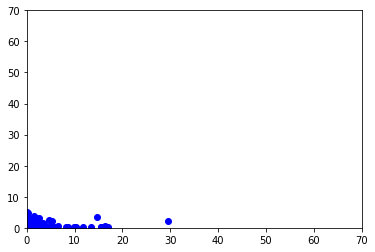

In [28]:
model_10 = xgb.XGBRegressor(learning_rate= 0.02, 
      gamma = 0.5, 
      min_child_weight = 5,
      nthread = 15,
      max_depth= 10,
      subsample= 0.9,
      eval_metric= 'rmse',
      colsample_bytree= 0.8, 
      n_estimators=500,
      max_leaves=300)

select_10 = SelectFromModel(model_10, threshold="1.6*mean")
select_10.fit(X_train_10,y_train_10)

X_train_s1_10 = select_10.transform(X_train_10)
X_test_s1_10 = select_10.transform(X_test_10)
  
print("X_train_s1.shape : {}".format(X_train_s1_10.shape))
  

X = X_train_s1_10
y = y_train_10
y= y.reset_index(drop=True)


kf = KFold(n_splits=10)
kf.get_n_splits(X)

print(kf)  

KFold(n_splits=10, random_state=None, shuffle=False)
for train_index, test_index in kf.split(X):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_test, label=y_test)
dtest = xgb.DMatrix(X_test_s1_10)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

# Try different parameters! My favorite is random search :)
xgb_pars = {'learning_rate': 0.01, 
    'gamma' : 0.5, 
    'min_child_weight' : 10,
    'nthread' : 15,
    'max_depth' : 10,
    'subsample' : 0.9,
    'eval_metric' : 'rmse',
    'colsample_bytree' : 0.8, 
    'num_boost_round' : 500,
    'n_estimators': 500,
    'max_leaves': 300,
    'objective': 'reg:linear'}
model = xgb.train(xgb_pars, dtrain, 500, watchlist, early_stopping_rounds=50,
                  maximize=False, verbose_eval=15)
#plt.figure(figsize=(15,10))
y_pred = model.predict(dtest)

real = y_test_10.reset_index()
real['amount_spent_pred'] = y_pred

linreg_RMSEk = np.sqrt(mse(real['amount_spent_pred'], real['amount_spent_y']))

print(linreg_RMSEk)
plt.plot(real['amount_spent_y'],real['amount_spent_pred'],'bo')
plt.axis([0, 70, 0, 70]); plt.show()

In [23]:
real.head()

,index,amount_spent_y
0,10004,0.586104
1,31748,1.094806
2,32085,0.984331
3,38115,3.445160
4,3670,0.720432


1.7145185534427878


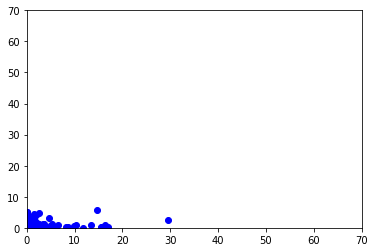

In [25]:
y_pred = model.predict(dtest)

real = y_test_10.reset_index()
real['amount_spent_pred'] = y_pred

linreg_RMSEk = np.sqrt(mse(real['amount_spent_pred'], real['amount_spent_y']))

print(linreg_RMSEk)
plt.plot(real['amount_spent_y'],real['amount_spent_pred'],'bo')
plt.axis([0, 70, 0, 70]); plt.show()

In [0]:
y_test_ta.reset_index()

Booster 0.9871666666666666
Booster 0.012820512820512822
[0.9871655971330944, 1.0]
1차 분류될 일평균결제량 1 이상인 유저 비율 :  0.0064516129032258064
실제 일평균결제량 1 이상인 유저 수 :  155
1차 분류될 일평균결제량 1 이상인 유저 수 :  1
임계값 :  0.7


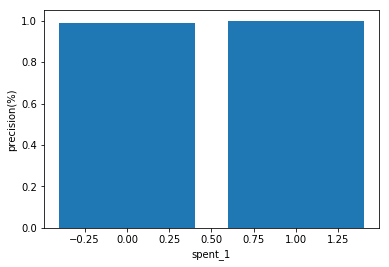

In [56]:
# 민감도, 재현성 비교를 위해 실제 값과 예측값을 하나의 df로 만듦
y_pred_under_10 = np.where(model.predict(dtest) > 0.9, 1, 0)
pred_under_10 = y_test_ta.reset_index()
pred_under_10['under_10_pred'] = y_pred_under_10


aa10 = []
for i in range(0,2):
    cc10 = np.where((pred_under_10['spent_1']==i) & (pred_under_10['under_10_pred']==i), 1, 0).sum() / pred_under_10[pred_under_10['under_10_pred']==i]['spent_1'].count()
    aa10.append(cc10)

aanp10 = np.array(aa10)
x = np.arange(0,2)
plt.bar(x,aa10)
plt.xlabel('spent_1')
plt.ylabel('precision(%)')
print(model.__class__.__name__, accuracy_score(y_test_ta, y_pred_under_10))
print(model.__class__.__name__, f1_score(y_test_ta, y_pred_under_10))
print(aa10)
print('1차 분류될 일평균결제량 1 이상인 유저 비율 : ', pred_under_10[pred_under_10['under_10_pred']==1]['under_10_pred'].count() / pred_under_10[pred_under_10['spent_1']==1]['spent_1'].count())
print('실제 일평균결제량 1 이상인 유저 수 : ',pred_under_10[pred_under_10['spent_1']==1]['spent_1'].count())
print('1차 분류될 일평균결제량 1 이상인 유저 수 : ',pred_under_10[pred_under_10['under_10_pred']==1]['under_10_pred'].count())
print('임계값 : ', 0.7)
# 분류 불가능

저장 코드

In [35]:
import pickle
from sklearn.externals import joblib 
# 객체를 pickled binary file 형태로 저장한다 
file_name = '/content/drive/My Drive/xgb_total_63.pkl' 

joblib.dump(model, file_name)

['/content/drive/My Drive/xgb_total_63.pkl']

In [34]:
import pickle
from sklearn.externals import joblib 
# 객체를 pickled binary file 형태로 저장한다 
file_name = '/content/drive/My Drive/select_total_0.9mean_63.pkl' 

joblib.dump(select_ta, file_name)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


['/content/drive/My Drive/select_total_0.9mean_63.pkl']

In [20]:
# 모델 로드
import pickle

select0_1 = pickle.load(open('/content/drive/My Drive/select_total_353_0.5mean_63.pkl','rb')) # selector 
model2 = pickle.load(open('/content/drive/My Drive/xgb_total_353_0.5mean_63.pkl' ,'rb')) # model

[16:42:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [0]:
testt = select0_1.transform(data[data.columns[1:]])
result = model2.predict(xgb.DMatrix(testt))

In [0]:
result = model2.predict(xgb.DMatrix(testt))

----------

5.417753295702465


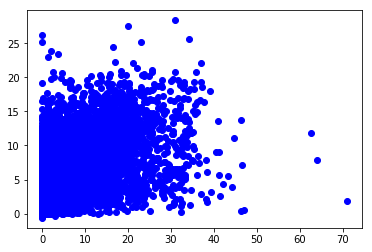

In [38]:
y_pred_ta = model_ta.predict(xgb.DMatrix(X_test_s1_ta))
ta_real = y_test_ta.reset_index()
ta_real['total_spent_pred'] = y_pred_ta
linreg_RMSEk_ta = np.sqrt(mse(ta_real['total_spent_pred'], ta_real['total_spent']))
print(linreg_RMSEk_ta)
#plt.figure(figsize=(15,10))

plt.plot(ta_real['total_spent'],ta_real['total_spent_pred'],'bo')
# mean, 78개 변수

생존기간 예측

In [57]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data[data.columns[1:]], train_label['survival_time']-1, test_size=0.3, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

X_train.shape, X_test.shape, X_valid.shape,y_train.shape, y_test.shape, y_valid.shape

((21000, 400), (12000, 400), (7000, 400), (21000,), (12000,), (7000,))

In [0]:
import xgboost as xgb

params =   {
    'learning_rate': 0.02, 
    'gamma' : 0.3, 
    'min_child_weight' : 3,
    'nthread' : 15,
    'max_depth' : 30,
    'subsample' : 0.9,
    'eval_metric' : 'merror',
    'colsample_bytree' : 0.8, 
    'num_boost_round' : 500,
    'n_estimators': 500,
    'max_leaves': 300,
    'objective': 'multi:softprob',
    'num_class': 64
}

In [0]:
%%time
VALID = True
if VALID == True:

    tr_data = xgb.DMatrix(X_train, y_train)
    va_data = xgb.DMatrix(X_valid, y_valid)

    #del X_train, X_valid, y_train, y_valid  ; gc.collect()

    watchlist = [(tr_data, 'train'), (va_data, 'valid')]

    model = xgb.train(params, tr_data, 500, watchlist, maximize=False, 
                      early_stopping_rounds = 30, verbose_eval=50)

# test(임계점 실험- 효과가 있다.)

In [0]:
# 파일 불러오기
test1 = pd.read_csv('/content/drive/My Drive/merge_all_flatten_test1.csv')    
test2 = pd.read_csv('/content/drive/My Drive/merge_all_flatten_test2.csv')   

In [0]:
# 총결제량
# test1
select_t1 = select0_1.transform(test1[test1.columns[1:]])
result_t1 = model2.predict(xgb.DMatrix(select_t1))
# test2
select_t2 = select0_1.transform(test2[test2.columns[1:]])
result_t2 = model2.predict(xgb.DMatrix(select_t2))

In [0]:
# 생존기간
# 모델 로드
import pickle
churn_xgb = pickle.load(open('/content/drive/My Drive/xgb_churn_surv_0828.pickle.dat','rb'))

In [0]:
# 파일 불러오기

test1s = pd.read_csv('/content/drive/My Drive/test1_129features.csv')    
test2s = pd.read_csv('/content/drive/My Drive/test2_129features.csv')   

sresult_t1 = churn_xgb.predict(xgb.DMatrix(test1s[test1s.columns[1:]]))
sresult_t2 = churn_xgb.predict(xgb.DMatrix(test2s[test2s.columns[1:]]))

In [24]:
sresult_t1[2]

array([0.09202335, 0.09031307, 0.01921072, 0.04740708, 0.03005288,
       0.00811143, 0.00826792, 0.02691986, 0.03219634, 0.01635264,
       0.01061933, 0.0215851 , 0.01236881, 0.01506243, 0.00749124,
       0.0304031 , 0.00803252, 0.01074623, 0.00853558, 0.00894163,
       0.01156313, 0.01780087, 0.01382382, 0.01598197, 0.01227232,
       0.01586423, 0.01013037, 0.0125211 , 0.0250978 , 0.01442922,
       0.01188967, 0.00623161, 0.00713461, 0.01225149, 0.007288  ,
       0.00646537, 0.00804117, 0.01325631, 0.00554862, 0.00842007,
       0.00606997, 0.01923958, 0.00570356, 0.01065416, 0.00654823,
       0.00857075, 0.00637624, 0.00954414, 0.0057642 , 0.00639834,
       0.0087019 , 0.00805764, 0.00693964, 0.00609461, 0.00864177,
       0.00738132, 0.01330982, 0.0100491 , 0.00538515, 0.00900174,
       0.00733252, 0.00656257, 0.00565565, 0.07136436], dtype=float32)

In [0]:
category_surv_pred = sresult_t1.argmax(axis=1) +1
category_test1 = DataFrame(category_surv_pred, columns=['survival_time'])
category_test1['1_prob'] = sresult_t1[:,0]
#category_test1['survival_time'] = np.where((category_test1['64_prob']<=0.9) & (category_test1['survival_time']==64), 30,category_test1['survival_time'])

In [28]:
category_test1[category_test1['survival_time']==1]

,survival_time,1_prob
2,1,0.092023
6,1,0.249317
35,1,0.152186
36,1,0.438743
57,1,0.132132
62,1,0.084913
75,1,0.469266
101,1,0.163561
116,1,0.138910
122,1,0.476058


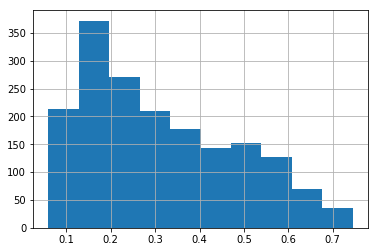

In [30]:
category_test1[category_test1['survival_time']==1]['1_prob'].hist()

In [0]:
category_surv_pred2 = sresult_t2.argmax(axis=1) +1
category_test2 = DataFrame(category_surv_pred2, columns=['survival_time'])
category_test2['64_prob'] = sresult_t2[:,-1]
category_test2['survival_time'] = np.where((category_test2['64_prob']<=0.9) & (category_test2['survival_time']==64), 30,category_test2['survival_time'])

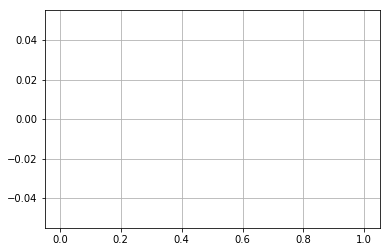

In [263]:
category_test2[category_test2['survival_time']==64]['64_prob'].hist()

(array([27667.,  3844.,  2320.,  1644.,  1252.,  1017.,   699.,   487.,
          358.,   242.]),
 array([ 0.,  3.,  6.,  9., 12., 15., 18., 21., 24., 27., 30.]),
 <a list of 10 Patch objects>)

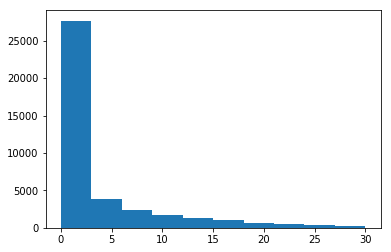

In [237]:
# 훈련 셋의 총결제량
plt.hist(data_lbl['total_spent'], range=(0,30))

(array([1.4619e+04, 3.8150e+03, 1.3850e+03, 1.4700e+02, 2.2000e+01,
        3.0000e+00, 2.0000e+00, 2.0000e+00, 5.0000e+00, 0.0000e+00]),
 array([ 0.,  3.,  6.,  9., 12., 15., 18., 21., 24., 27., 30.],
       dtype=float32),
 <a list of 10 Patch objects>)

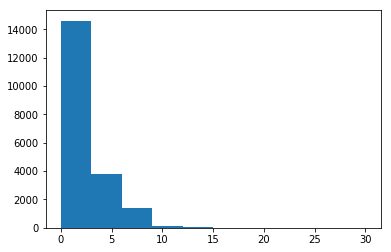

In [266]:
plt.hist(result_t1, range=(0,30))

(array([4.122e+03, 8.898e+03, 2.972e+03, 1.960e+03, 1.393e+03, 5.370e+02,
        8.300e+01, 2.200e+01, 8.000e+00, 5.000e+00]),
 array([-2.9212582 ,  0.22603253,  3.3733232 ,  6.520614  ,  9.667905  ,
        12.815195  , 15.962486  , 19.109777  , 22.257067  , 25.404358  ,
        28.55165   ], dtype=float32),
 <a list of 10 Patch objects>)

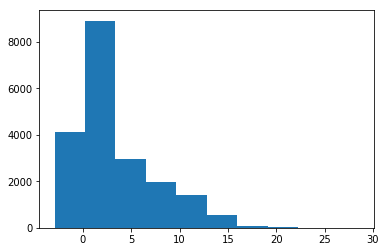

In [235]:
# 테스트 1의 총결제량 값
data_lbl.

In [0]:
category_test1 = category_test1.drop('64_prob',axis=1)
category_test2 = category_test2.drop('64_prob',axis=1)

In [0]:
# amount_spent
category_test1['total_spent'] = result_t1
category_test1['amount_spent'] = category_test1['total_spent'] / category_test1['survival_time']

category_test2['total_spent'] = result_t2
category_test2['amount_spent'] = category_test2['total_spent'] / category_test2['survival_time']



# del total_spent 
category_test1 = category_test1.drop('total_spent',axis=1)
category_test2 = category_test2.drop('total_spent',axis=1)

# 0 이하의 결제량은 0으로
category_test1['amount_spent'] = np.where(category_test1['amount_spent']<0, 0,category_test1['amount_spent'])

category_test2['amount_spent'] = np.where(category_test2['amount_spent']<0, 0,category_test2['amount_spent'])

In [0]:
# 64로 예측하면 결제량 0으로 변경
category_test1['amount_spent'] = np.where(category_test1['survival_time']==64, 0,category_test1['amount_spent'])

category_test2['amount_spent'] = np.where(category_test2['survival_time']==64, 0,category_test2['amount_spent'])
## 

In [0]:
test11 = pd.concat([test1[['acc_id']], category_test1], axis=1)
test22 = pd.concat([test2[['acc_id']], category_test2], axis=1)

In [0]:
test11.to_csv('/content/drive/My Drive/test1_predict.csv', index=False)
test22.to_csv('/content/drive/My Drive/test2_predict.csv', index=False)

In [272]:
test11.head()

,acc_id,survival_time,amount_spent
0,7,30,0.024417
1,15,30,0.002794
2,16,1,0.202482
3,18,30,0.008683
4,19,30,0.073571


In [219]:
test11.head()

,acc_id,survival_time,amount_spent
0,7,30,0.059473
1,15,30,0.001826
2,16,1,1.913509
3,18,30,0.007677
4,19,30,0.191274


(array([1.9780e+03, 2.0500e+02, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        1.2000e+01, 3.0000e+00, 1.7795e+04, 0.0000e+00, 6.0000e+00]),
 array([ 1. ,  4.8,  8.6, 12.4, 16.2, 20. , 23.8, 27.6, 31.4, 35.2, 39. ]),
 <a list of 10 Patch objects>)

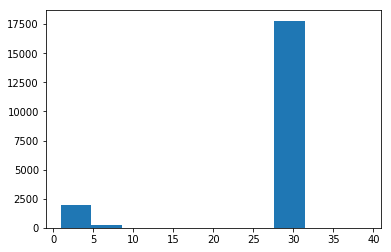

In [220]:
plt.hist(test11['survival_time'])